In [110]:
# !pip install scikeras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# from scikeras.wrappers import KerasClassifier

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping



## Import Data

In [111]:
data = pd.read_csv('./demographics-data/classification_data_demographics.csv')
data.head(2)

,MonthOccurrence,TotalNumberOfVictims,TotalNumberOfIndividualVictims,SuspectsRaceAsAGroup,TotalNumberOfSuspects,MostSeriousUcr,MostSeriousUcrType,MostSeriousLocation,MostSeriousBias,MostSeriousBiasType,...,pct_Asian,pct_AAPI,pct_Black,pct_Hispanic,pct_Multi-Racial/Ethnic,pct_Hawaiian/ Pacific Island,pct_White,pct_unemployed_2018,pct_u18_poverty_2017,median_hh_income_2017
0,2,1,1,White,2,Simple Assault,Violent Crimes,Bar/Night Club,Anti-Black or African American,Race/Ethnicity/Ancestry,...,0.265963,0.27413,0.115603,0.234718,0.041847,0.008167,0.337067,0.03,0.105,95550.0
1,2,2,2,White,1,Destruction/Damage/Vandalism,Property Crimes,Residence/Home/Driveway,Anti-Black or African American,Race/Ethnicity/Ancestry,...,0.265963,0.27413,0.115603,0.234718,0.041847,0.008167,0.337067,0.03,0.105,95550.0


## Transform and Scale Data

### Column Transformer

In [112]:
X = data.drop(columns=['labels'])
ct = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
    remainder='passthrough',
    verbose_feature_names_out=False
)
X_encoded = ct.fit_transform(X)
X_encoded
ct.get_feature_names_out()
X_encoded = pd.DataFrame(X_encoded, columns=ct.get_feature_names_out())

X_encoded.head(2)

,SuspectsRaceAsAGroup_American Indian or Alaska Native,SuspectsRaceAsAGroup_Asian,SuspectsRaceAsAGroup_Asian/Pacific Islander,SuspectsRaceAsAGroup_Black or African American,SuspectsRaceAsAGroup_East Indian,SuspectsRaceAsAGroup_East Indian/Asian Indian,SuspectsRaceAsAGroup_Group of Multiple Races,SuspectsRaceAsAGroup_Hispanic,SuspectsRaceAsAGroup_Native Hawaiian or Other Pacific Islander,SuspectsRaceAsAGroup_Unknown,...,pct_Asian,pct_AAPI,pct_Black,pct_Hispanic,pct_Multi-Racial/Ethnic,pct_Hawaiian/ Pacific Island,pct_White,pct_unemployed_2018,pct_u18_poverty_2017,median_hh_income_2017
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.265963,0.27413,0.115603,0.234718,0.041847,0.008167,0.337067,0.03,0.105,95550.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.265963,0.27413,0.115603,0.234718,0.041847,0.008167,0.337067,0.03,0.105,95550.0


### Scaling

In [113]:
X_encoded_scaled = StandardScaler().fit_transform(X_encoded)

## Target

In [114]:
y = data['labels']

y_categorical = to_categorical(y, 3)

## Baseline

In [115]:
y.value_counts(normalize=True)

1    0.728433
0    0.168726
2    0.102840
Name: labels, dtype: float64

## Test/Train Split


In [116]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded_scaled, y_categorical, stratify=y, random_state=13)

X_train.shape

y_train.shape

(18327, 3)

## Random Forest

In [117]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.999836307087903

### Confusion Matrix Display

In [118]:
y_preds = rf.predict(X_test)

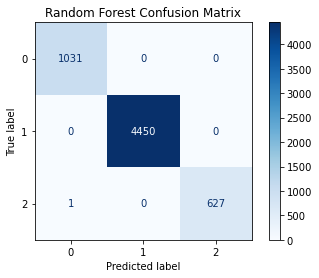

In [119]:
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), np.rint(y_preds).argmax(axis=1), cmap='Blues')
;
plt.title("Random Forest Confusion Matrix")
plt.savefig('./figures/confusion_matrix_random_forest.png')

### Balanced Accuracy Score

In [120]:
balanced_accuracy_score(y_test.argmax(axis=1), y_preds.argmax(axis=1))

0.9994692144373672

### Feature Importances

In [132]:
pd.DataFrame([ct.get_feature_names_out(), rf.feature_importances_]).T.sort_values(by=1, ascending=False).head(10)

,0,1
150,population,0.130734
152,pct_AAPI,0.114012
160,median_hh_income_2017,0.102915
154,pct_Hispanic,0.094393
151,pct_Asian,0.091557
159,pct_u18_poverty_2017,0.088398
158,pct_unemployed_2018,0.086405
155,pct_Multi-Racial/Ethnic,0.073845
156,pct_Hawaiian/ Pacific Island,0.06919
157,pct_White,0.068141


## Extra Trees

In [ ]:
et = ExtraTreesClassifier(n_jobs=-1)
et.fit(X_train, y_train)
et.score(X_test, y_test)

0.9996726141758062

### Confusion Matrix Display

In [ ]:
y_preds = et.predict(X_test)

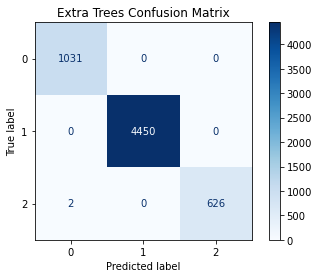

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), np.rint(y_preds).argmax(axis=1), cmap='Blues')
;
plt.title("Extra Trees Confusion Matrix")
plt.savefig('./figures/confusion_matrix_extra_trees.png')

### Balanced Accuracy Score

In [ ]:
balanced_accuracy_score(y_test.argmax(axis=1), y_preds.argmax(axis=1))

0.9989384288747346

## RandomizedSearchCV on Extra Trees

### Extra Trees

In [ ]:
et = ExtraTreesClassifier()

In [ ]:
et.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [ ]:
params = {
    'n_estimators': range(100, 1000)
}

### RandomizedSearchCV

In [ ]:
# rs = RandomizedSearchCV(
#     et,
#     params,
#     n_jobs=-1
# )

# rs_result = rs.fit(X_train, y_train)

# # Result summary
# print(f"Best score: {rs_result.best_score_}. Used these parameters: {rs_result.best_params_}")

# # This part copied from machine learning mastery prints out all results to check where improvements can be made
# means = rs_result.cv_results_['mean_test_score']
# stds = rs_result.cv_results_['std_test_score']
# params = rs_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# y_preds = rs_result.best_estimator_.predict(X_test)

In [ ]:
# balanced_accuracy_score(y_test.argmax(axis=1), y_preds.argmax(axis=1))